In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import pickle
import warnings
import gc
from datetime import datetime
import json
from tqdm import tqdm
from joblib import Parallel, delayed
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import (
    f1_score, matthews_corrcoef, accuracy_score, confusion_matrix,
    precision_score, recall_score, classification_report,
    balanced_accuracy_score
)
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE, BorderlineSMOTE, ADASYN

In [2]:
SEED = 42
np.random.seed(SEED)

N_JOBS_MODELS = 4  
N_JOBS_CV = 3      

ROOT = Path(r"C:\Computer Science\AIMLDL\log-anomaly-detection")
FEAT_PATH = ROOT / "features"

MODELS_PATH = ROOT / "models" / "ml_models"
RESULTS_PATH = ROOT / "results"

MODELS_PATH.mkdir(parents=True, exist_ok=True)
RESULTS_PATH.mkdir(parents=True, exist_ok=True)

print(f"Models will be saved to: {MODELS_PATH}")
print(f"Results will be saved to: {RESULTS_PATH}")
print(f"Classes: 7")

LABEL_MAP = {
    0: 'normal',
    1: 'security_anomaly',
    2: 'system_failure',
    3: 'performance_issue',
    4: 'network_anomaly',
    5: 'config_error',
    6: 'hardware_issue'
}

Models will be saved to: C:\Computer Science\AIMLDL\log-anomaly-detection\models\ml_models
Results will be saved to: C:\Computer Science\AIMLDL\log-anomaly-detection\results
Classes: 7


In [3]:
feat_file = FEAT_PATH / "pyspark_hybrid_features.pkl"
if not feat_file.exists():
    print(f"Error: {feat_file} not found")
    exit(1)

with open(feat_file, 'rb') as f:
    feat_data = pickle.load(f)
    dat = feat_data['hybrid_features_data']
    num_classes = feat_data.get('num_classes', 7)

split_file = FEAT_PATH / "pyspark_cross_source_splits.pkl"
if not split_file.exists():
    print(f"Error: {split_file} not found")
    exit(1)

with open(split_file, 'rb') as f:
    split_data = pickle.load(f)
    splts = split_data['splits']

optimal_config_file = ROOT / "dataset" / "labeled_data" / "normalized" / "optimal_class_config.json"
if optimal_config_file.exists():
    with open(optimal_config_file, 'r') as f:
        optimal_config = json.load(f)
else:
    optimal_config = None

In [4]:
def calculate_focal_weights(y, alpha=0.25, gamma=2.0):
    unique_classes, class_counts = np.unique(y, return_counts=True)
    total_samples = len(y)
    
    weights = {}
    for cls, count in zip(unique_classes, class_counts):
        frequency = count / total_samples
        weight = alpha * (1 - frequency) ** gamma
        weights[cls] = weight
    
    weight_sum = sum(weights.values())
    weights = {k: v/weight_sum * len(weights) for k, v in weights.items()}
    
    return weights

In [5]:
def apply_advanced_sampling(X_tr, y_tr):    
    unique, counts = np.unique(y_tr, return_counts=True)
    class_dist = dict(zip(unique, counts))
    
    max_count = max(counts)
    min_count = min(counts)
    imbalance_ratio = max_count / min_count
    
    if imbalance_ratio < 3:
        return X_tr, y_tr
    
    min_samples_for_smote = min(counts)
    if min_samples_for_smote <= 1:
        return X_tr, y_tr
    
    k_neighbors = min(5, min_samples_for_smote - 1)
    
    try:
        if imbalance_ratio > 100:
            sampler = ADASYN(random_state=SEED, n_neighbors=k_neighbors, n_jobs=2)
        elif imbalance_ratio > 10:
            sampler = BorderlineSMOTE(random_state=SEED, k_neighbors=k_neighbors, n_jobs=2)
        else:
            sampler = SMOTE(random_state=SEED, k_neighbors=k_neighbors, n_jobs=2)
            
        X_res, y_res = sampler.fit_resample(X_tr, y_tr)
        
        return X_res, y_res
        
    except Exception as e:
        return X_tr, y_tr

In [6]:
def calculate_geometric_mean(y_true, y_pred):
    unique_classes = np.unique(y_true)
    recalls = []
    
    for class_id in unique_classes:
        y_true_binary = (y_true == class_id).astype(int)
        y_pred_binary = (y_pred == class_id).astype(int)
        recall = recall_score(y_true_binary, y_pred_binary, zero_division=0)
        recalls.append(recall)
    
    if len(recalls) > 0 and all(r >= 0 for r in recalls):
        recalls = [max(r, 1e-10) for r in recalls]
        return np.prod(recalls) ** (1/len(recalls))
    return 0.0

def calculate_iba(y_true, y_pred, alpha=0.1):
    balanced_acc = balanced_accuracy_score(y_true, y_pred)
    geometric_mean = calculate_geometric_mean(y_true, y_pred)
    iba = (1 + alpha * geometric_mean) * balanced_acc
    return iba

def calc_enhanced_metrics(y_true, y_pred, y_proba=None):
    metrics = {}
    
    metrics['acc'] = accuracy_score(y_true, y_pred)
    metrics['bal_acc'] = balanced_accuracy_score(y_true, y_pred)
    metrics['f1_macro'] = f1_score(y_true, y_pred, average='macro', zero_division=0)
    metrics['f1_weighted'] = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    metrics['f1_micro'] = f1_score(y_true, y_pred, average='micro', zero_division=0)
    metrics['mcc'] = matthews_corrcoef(y_true, y_pred)
    
    metrics['geometric_mean'] = calculate_geometric_mean(y_true, y_pred)
    metrics['iba'] = calculate_iba(y_true, y_pred)
    
    per_class_metrics = {}
    unique_classes = np.unique(np.concatenate([y_true, y_pred]))
    
    for class_id in unique_classes:
        y_true_binary = (y_true == class_id).astype(int)
        y_pred_binary = (y_pred == class_id).astype(int)
        
        if y_true_binary.sum() > 0:
            per_class_metrics[int(class_id)] = {
                'precision': precision_score(y_true_binary, y_pred_binary, zero_division=0),
                'recall': recall_score(y_true_binary, y_pred_binary, zero_division=0),
                'f1': f1_score(y_true_binary, y_pred_binary, zero_division=0),
                'support': int(y_true_binary.sum()),
                'frequency': float(y_true_binary.sum() / len(y_true))
            }
    
    metrics['per_class'] = per_class_metrics
    
    cm = confusion_matrix(y_true, y_pred)
    metrics['confusion_matrix'] = cm.tolist()
    
    return metrics

In [7]:
mod_config = {
    'lr': {
        'model': LogisticRegression(random_state=SEED, max_iter=2000, 
                                    multi_class='multinomial', n_jobs=N_JOBS_CV),
        'p': {'C': [0.1, 1.0, 10.0], 'solver': ['lbfgs']},
    },
    'rf': {
        'model': RandomForestClassifier(random_state=SEED, n_jobs=N_JOBS_CV),
        'p': {'n_estimators': [100, 200], 'max_depth': [10, 20, None]},
    },
    'xgb': {
        'model': XGBClassifier(random_state=SEED, eval_metric='mlogloss', 
                              n_jobs=N_JOBS_CV, tree_method='hist', 
                              objective='multi:softmax', num_class=7),
        'p': {'n_estimators': [100, 200], 'learning_rate': [0.05, 0.1], 
              'max_depth': [3, 5, 7]},
    },
    'gb': {
        'model': GradientBoostingClassifier(random_state=SEED),
        'p': {'n_estimators': [100, 200], 'learning_rate': [0.01, 0.1], 
              'max_depth': [3, 5]},
    },
    'svm': {
        'model': SVC(random_state=SEED, probability=True, 
                    decision_function_shape='ovr', cache_size=2000),
        'p': {'C': [1, 10], 'kernel': ['rbf'], 'gamma': ['scale', 'auto']},
    },
    'knn': {
        'model': KNeighborsClassifier(n_jobs=N_JOBS_CV),
        'p': {'n_neighbors': [5, 7, 9], 'weights': ['uniform', 'distance']},
    },
    'dt': {
        'model': DecisionTreeClassifier(random_state=SEED),
        'p': {'max_depth': [10, 20, None], 'min_samples_split': [2, 5, 10]},
    },
    'nb': {
        'model': GaussianNB(),
        'p': {'var_smoothing': [1e-9, 1e-8, 1e-7]},
    }
}

In [8]:
def train_single_model(m_name, m_config, X_tr, y_tr, X_ts, y_ts, class_weights):
    try:
        n_splits = min(3, max(2, len(y_tr) // 50))
        
        if hasattr(m_config['model'], 'class_weight'):
            m_config['model'].set_params(class_weight=class_weights)
        
        if len(m_config['p']) > 0:
            cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=SEED)
            
            grid = GridSearchCV(
                m_config['model'],
                m_config['p'],
                cv=cv,
                scoring='f1_macro',
                n_jobs=1,  
                verbose=0
            )
            grid.fit(X_tr, y_tr)
            best_model = grid.best_estimator_
            best_params = grid.best_params_
        else:
            best_model = m_config['model']
            best_model.fit(X_tr, y_tr)
            best_params = {}
        
        y_pred = best_model.predict(X_ts)
        
        try:
            y_proba = best_model.predict_proba(X_ts)
        except AttributeError:
            y_proba = None
        
        metrics = calc_enhanced_metrics(y_ts, y_pred, y_proba)
        
        return m_name, {
            'metrics': metrics,
            'params': best_params,
            'model': best_model
        }
        
    except Exception as e:
        return m_name, {'error': str(e)}

In [9]:
feat_type_to_test = 'all_features'
first_split = splts[0]

test_src = first_split['test_source']
train_srcs = first_split['train_sources']

if test_src not in dat or dat[test_src]['labels'] is None:
    print("Error: Test source not available")
    exit(1)

if feat_type_to_test not in dat[test_src]['feature_variants']:
    print("Error: Feature type not available")
    exit(1)

test_data = dat[test_src]
X_ts = test_data['feature_variants'][feat_type_to_test]
y_ts = test_data['labels']

X_tr_list, y_tr_list = [], []
for src in train_srcs:
    if src in dat and dat[src]['labels'] is not None:
        if feat_type_to_test in dat[src]['feature_variants']:
            X_tr_list.append(dat[src]['feature_variants'][feat_type_to_test])
            y_tr_list.append(dat[src]['labels'])

if not X_tr_list:
    print("Error: No training data available")
    exit(1)

X_tr = np.vstack(X_tr_list)
y_tr = np.concatenate(y_tr_list)

if len(np.unique(y_tr)) < 2:
    print("Error: Insufficient classes in training data")
    exit(1)

sc = StandardScaler()
X_tr_sc = sc.fit_transform(X_tr)
X_ts_sc = sc.transform(X_ts)

X_tr_res, y_tr_res = apply_advanced_sampling(X_tr_sc, y_tr)

focal_weights = calculate_focal_weights(y_tr_res)

In [10]:
results = {}
model_items = list(mod_config.items())

parallel_results = Parallel(n_jobs=N_JOBS_MODELS, backend='loky', verbose=10)(
    delayed(train_single_model)(name, config, X_tr_res, y_tr_res, X_ts_sc, y_ts, focal_weights)
    for name, config in model_items
)

for name, result in parallel_results:
    results[name] = result
    gc.collect()

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   8 | elapsed:  2.8min remaining:  8.5min
[Parallel(n_jobs=4)]: Done   3 out of   8 | elapsed:  3.1min remaining:  5.2min
[Parallel(n_jobs=4)]: Done   4 out of   8 | elapsed:  6.9min remaining:  6.9min
[Parallel(n_jobs=4)]: Done   5 out of   8 | elapsed:  7.0min remaining:  4.2min
[Parallel(n_jobs=4)]: Done   6 out of   8 | elapsed:  7.2min remaining:  2.4min
[Parallel(n_jobs=4)]: Done   8 out of   8 | elapsed: 143.4min finished


In [11]:
comparison_data = []

for model_name, result in results.items():
    if 'error' not in result:
        metrics = result['metrics']
        comparison_data.append({
            'Model': model_name.upper(),
            'F1-Macro': metrics.get('f1_macro', 0),
            'F1-Weighted': metrics.get('f1_weighted', 0),
            'Balanced Acc': metrics.get('bal_acc', 0),
            'Geometric Mean': metrics.get('geometric_mean', 0),
            'IBA': metrics.get('iba', 0),
            'MCC': metrics.get('mcc', 0)
        })

In [12]:
if comparison_data:
    df_comparison = pd.DataFrame(comparison_data)
    df_comparison = df_comparison.sort_values('F1-Macro', ascending=False)
    
    best_row = df_comparison.iloc[0]
    best_model_name = best_row['Model'].lower()
    
    if best_model_name in results:
        per_class = results[best_model_name]['metrics'].get('per_class', {})
        
        for class_id in sorted(per_class.keys()):
            class_metrics = per_class[class_id]
            class_name = LABEL_MAP[class_id]

In [13]:
all_train_srcs = [s for s in dat.keys() if dat[s]['labels'] is not None]

X_tr_list_all, y_tr_list_all = [], []
for src in all_train_srcs:
    if feat_type_to_test in dat[src]['feature_variants']:
        X_tr_list_all.append(dat[src]['feature_variants'][feat_type_to_test])
        y_tr_list_all.append(dat[src]['labels'])

X_tr_all = np.vstack(X_tr_list_all)
y_tr_all = np.concatenate(y_tr_list_all)

sc_final = StandardScaler()
X_tr_sc_all = sc_final.fit_transform(X_tr_all)

X_tr_res_all, y_tr_res_all = apply_advanced_sampling(X_tr_sc_all, y_tr_all)

focal_weights_final = calculate_focal_weights(y_tr_res_all)

best_model_config = mod_config[best_model_name]

if hasattr(best_model_config['model'], 'class_weight'):
    best_model_config['model'].set_params(class_weight=focal_weights_final)

if len(best_model_config['p']) > 0:
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
    grid = GridSearchCV(best_model_config['model'], best_model_config['p'], 
                       cv=cv, scoring='f1_macro', n_jobs=N_JOBS_CV, verbose=0)
    grid.fit(X_tr_res_all, y_tr_res_all)
    final_model = grid.best_estimator_
    final_params = grid.best_params_
else:
    from sklearn.base import clone
    final_model = clone(best_model_config['model'])
    final_model.fit(X_tr_res_all, y_tr_res_all)
    final_params = {}

In [14]:
deployment_dir = MODELS_PATH / "deployment"
deployment_dir.mkdir(exist_ok=True)

dep_data = {
    'model': final_model,
    'scaler': sc_final,
    'feature_type': feat_type_to_test,
    'model_name': best_model_name,
    'num_classes': 7,
    'label_map': LABEL_MAP,
    'best_params': final_params,
    'focal_weights': focal_weights_final,
    'metrics': {
        'f1_macro': float(best_row['F1-Macro']),
        'f1_weighted': float(best_row['F1-Weighted']),
        'balanced_acc': float(best_row['Balanced Acc']),
        'geometric_mean': float(best_row['Geometric Mean']),
        'iba': float(best_row['IBA']),
        'mcc': float(best_row['MCC']),
    },
    'training_samples': len(y_tr_res_all),
    'original_samples': len(y_tr_all),
    'phase1_enhanced': True,
    'timestamp': datetime.now().isoformat()
}

deployment_file = deployment_dir / "best_model_for_deployment.pkl"
with open(deployment_file, 'wb') as f:
    pickle.dump(dep_data, f)

print(f"DEPLOYMENT MODEL SAVED:")
print(f"   Location: {deployment_file}")
print(f"Model: {best_model_name.upper()}")
print(f"Training samples: {len(y_tr_res_all):,} (from {len(y_tr_all):,})")

DEPLOYMENT MODEL SAVED:
   Location: C:\Computer Science\AIMLDL\log-anomaly-detection\models\ml_models\deployment\best_model_for_deployment.pkl
Model: LR
Training samples: 18,000 (from 18,000)


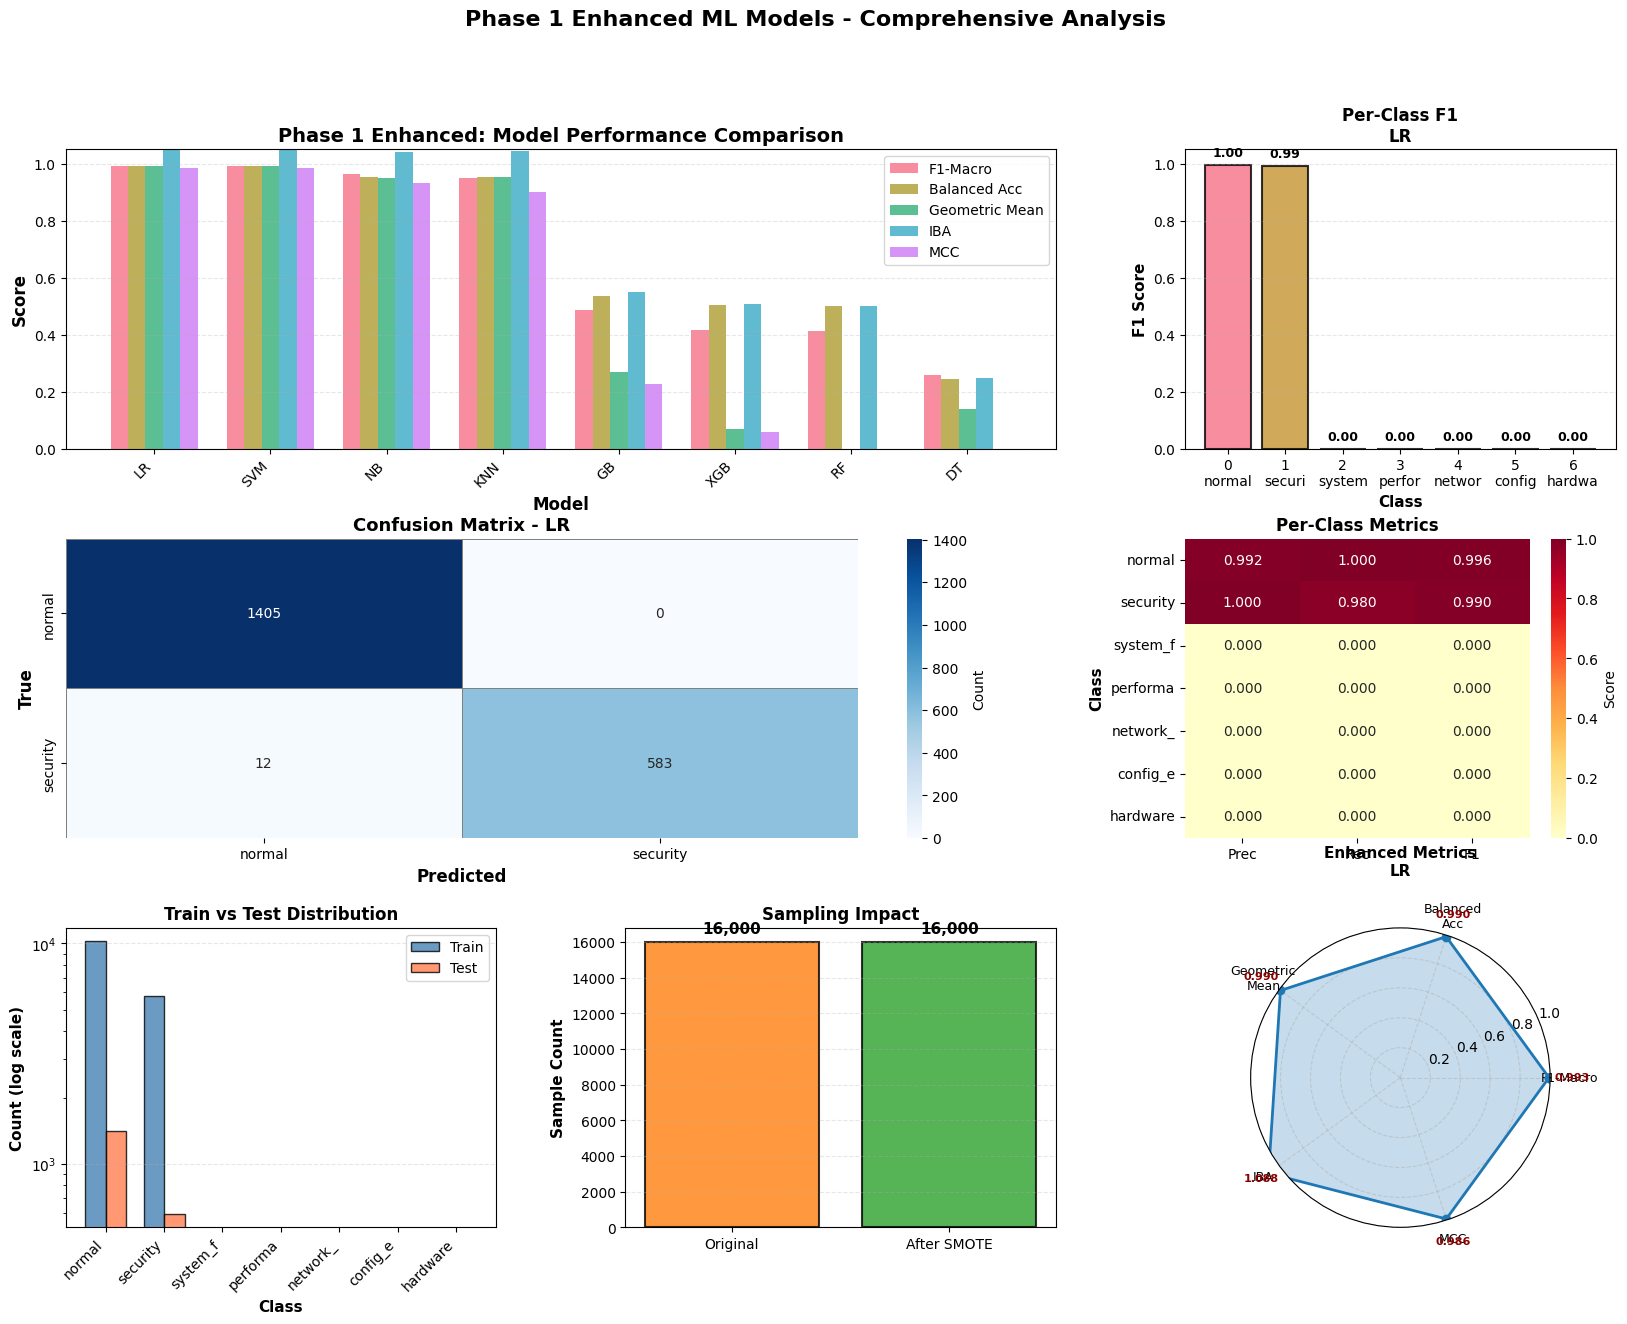


Visualizations saved to: C:\Computer Science\AIMLDL\log-anomaly-detection\results\ml_models_phase1_20251027_132106\results_visualization_Apache_2k.png
Comparison CSV saved to: C:\Computer Science\AIMLDL\log-anomaly-detection\results\ml_models_phase1_20251027_132106\model_comparison_Apache_2k.csv


<Figure size 640x480 with 0 Axes>

In [17]:
plt.style.use('default')
sns.set_palette("husl")

fig = plt.figure(figsize=(20, 14))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

ax1 = fig.add_subplot(gs[0, :2])
models = df_comparison['Model'].values
x = np.arange(len(models))
width = 0.15

metrics_to_plot = ['F1-Macro', 'Balanced Acc', 'Geometric Mean', 'IBA', 'MCC']
colors = sns.color_palette("husl", len(metrics_to_plot))

for i, metric in enumerate(metrics_to_plot):
    values = df_comparison[metric].values
    ax1.bar(x + i*width - 2*width, values, width, label=metric, 
            alpha=0.8, color=colors[i])

ax1.set_xlabel('Model', fontsize=12, fontweight='bold')
ax1.set_ylabel('Score', fontsize=12, fontweight='bold')
ax1.set_title('Phase 1 Enhanced: Model Performance Comparison', 
             fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels([m for m in models], rotation=45, ha='right')
ax1.legend(loc='upper right', fontsize=10)
ax1.grid(axis='y', alpha=0.3, linestyle='--')
ax1.set_ylim([0, 1.05])

ax2 = fig.add_subplot(gs[0, 2])
if best_model_name in results:
    per_class = results[best_model_name]['metrics'].get('per_class', {})
    classes = [f"{i}\n{LABEL_MAP[i][:6]}" for i in range(7)]
    f1_scores = [per_class.get(i, {}).get('f1', 0) for i in range(7)]
    
    bars = ax2.bar(classes, f1_scores, color=sns.color_palette("husl", 7), 
                   alpha=0.8, edgecolor='black', linewidth=1.5)
    ax2.set_xlabel('Class', fontsize=11, fontweight='bold')
    ax2.set_ylabel('F1 Score', fontsize=11, fontweight='bold')
    ax2.set_title(f'Per-Class F1\n{best_row["Model"]}', 
                 fontsize=12, fontweight='bold')
    ax2.grid(axis='y', alpha=0.3, linestyle='--')
    ax2.set_ylim([0, 1.05])
    
    for bar, score in zip(bars, f1_scores):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'{score:.2f}', ha='center', va='bottom', fontsize=9, 
                fontweight='bold')

ax3 = fig.add_subplot(gs[1, :2])
if best_model_name in results:
    cm = np.array(results[best_model_name]['metrics']['confusion_matrix'])
    n_classes = cm.shape[0]
    
    # Use actual number of classes present in confusion matrix
    class_labels = [LABEL_MAP.get(i, f'Class_{i}')[:8] for i in range(n_classes)]
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax3,
                cbar_kws={'label': 'Count'}, linewidths=0.5, linecolor='gray',
                xticklabels=class_labels,
                yticklabels=class_labels)
    ax3.set_xlabel('Predicted', fontsize=12, fontweight='bold')
    ax3.set_ylabel('True', fontsize=12, fontweight='bold')
    ax3.set_title(f'Confusion Matrix - {best_row["Model"]}', 
                 fontsize=13, fontweight='bold')

ax4 = fig.add_subplot(gs[1, 2])
if best_model_name in results:
    per_class = results[best_model_name]['metrics'].get('per_class', {})
    
    metrics_matrix = []
    for i in range(7):
        if i in per_class:
            metrics_matrix.append([
                per_class[i]['precision'],
                per_class[i]['recall'],
                per_class[i]['f1']
            ])
        else:
            metrics_matrix.append([0, 0, 0])
    
    sns.heatmap(metrics_matrix, annot=True, fmt='.3f', cmap='YlOrRd', 
                ax=ax4, cbar_kws={'label': 'Score'}, vmin=0, vmax=1,
                xticklabels=['Prec', 'Rec', 'F1'],
                yticklabels=[LABEL_MAP[i][:8] for i in range(7)])
    ax4.set_title('Per-Class Metrics', fontsize=12, fontweight='bold')
    ax4.set_ylabel('Class', fontsize=11, fontweight='bold')

ax5 = fig.add_subplot(gs[2, 0])
train_dist = {int(k): int(v) for k, v in zip(*np.unique(y_tr, return_counts=True))}
test_dist = {int(k): int(v) for k, v in zip(*np.unique(y_ts, return_counts=True))}

train_classes = sorted(train_dist.keys())
train_counts = [train_dist.get(c, 0) for c in range(7)]
test_counts = [test_dist.get(c, 0) for c in range(7)]

x_pos = np.arange(7)
width = 0.35

bars1 = ax5.bar(x_pos - width/2, train_counts, width, label='Train', 
                alpha=0.8, color='steelblue', edgecolor='black')
bars2 = ax5.bar(x_pos + width/2, test_counts, width, label='Test', 
                alpha=0.8, color='coral', edgecolor='black')

ax5.set_xlabel('Class', fontsize=11, fontweight='bold')
ax5.set_ylabel('Count (log scale)', fontsize=11, fontweight='bold')
ax5.set_title('Train vs Test Distribution', fontsize=12, fontweight='bold')
ax5.set_xticks(x_pos)
ax5.set_xticklabels([LABEL_MAP[c][:8] for c in range(7)], 
                     rotation=45, ha='right')
ax5.legend(fontsize=10)
ax5.set_yscale('log')
ax5.grid(axis='y', alpha=0.3, linestyle='--')

ax6 = fig.add_subplot(gs[2, 1])
sampling_data = {
    'Original': len(y_tr),
    'After SMOTE': len(y_tr_res)
}

colors_sampling = ['#ff7f0e', '#2ca02c']
bars = ax6.bar(sampling_data.keys(), sampling_data.values(), 
               color=colors_sampling, alpha=0.8, edgecolor='black', linewidth=1.5)
ax6.set_ylabel('Sample Count', fontsize=11, fontweight='bold')
ax6.set_title('Sampling Impact', fontsize=12, fontweight='bold')
ax6.grid(axis='y', alpha=0.3, linestyle='--')

for bar, (label, value) in zip(bars, sampling_data.items()):
    height = bar.get_height()
    ax6.text(bar.get_x() + bar.get_width()/2., height + height*0.02,
            f'{value:,}', ha='center', va='bottom', fontsize=11, fontweight='bold')

ax7 = fig.add_subplot(gs[2, 2], projection='polar')

categories = ['F1-Macro', 'Balanced\nAcc', 'Geometric\nMean', 'IBA', 'MCC']
values = [
    best_row['F1-Macro'],
    best_row['Balanced Acc'],
    best_row['Geometric Mean'],
    best_row['IBA'],
    best_row['MCC']
]

values_normalized = values.copy()
values_normalized[4] = (values[4] + 1) / 2

angles = np.linspace(0, 2 * np.pi, len(categories), endpoint=False).tolist()
values_normalized += values_normalized[:1]
angles += angles[:1]

ax7.plot(angles, values_normalized, 'o-', linewidth=2, color='#1f77b4')
ax7.fill(angles, values_normalized, alpha=0.25, color='#1f77b4')
ax7.set_xticks(angles[:-1])
ax7.set_xticklabels(categories, fontsize=9)
ax7.set_ylim(0, 1)
ax7.set_title(f'Enhanced Metrics\n{best_row["Model"]}', 
             fontsize=11, fontweight='bold', pad=20)
ax7.grid(True, linestyle='--', alpha=0.5)

for angle, value, cat in zip(angles[:-1], values, categories):
    ax7.text(angle, 1.15, f'{value:.3f}', ha='center', va='center',
            fontsize=8, fontweight='bold', color='darkred')

plt.suptitle('Phase 1 Enhanced ML Models - Comprehensive Analysis', 
            fontsize=16, fontweight='bold', y=0.98)

plt.show()

experiment_dir = RESULTS_PATH / f"ml_models_phase1_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
experiment_dir.mkdir(exist_ok=True)

plt.savefig(experiment_dir / f"results_visualization_{test_src}.png", 
            dpi=300, bbox_inches='tight', facecolor='white')
print(f"\nVisualizations saved to: {experiment_dir / f'results_visualization_{test_src}.png'}")

df_comparison.to_csv(experiment_dir / f"model_comparison_{test_src}.csv", index=False)
print(f"Comparison CSV saved to: {experiment_dir / f'model_comparison_{test_src}.csv'}")

In [19]:
if best_model_name in results:
    per_class = results[best_model_name]['metrics'].get('per_class', {})
    per_class_rows = []
    
    for class_id in sorted(per_class.keys()):
        metrics = per_class[class_id]
        per_class_rows.append({
            'Class_ID': class_id,
            'Class_Name': LABEL_MAP[class_id],
            'Precision': metrics['precision'],
            'Recall': metrics['recall'],
            'F1': metrics['f1'],
            'Support': metrics['support'],
            'Frequency': metrics['frequency']
        })
    
    df_per_class = pd.DataFrame(per_class_rows)
    per_class_file = experiment_dir / f"phase1_per_class_{best_model_name}_{test_src}.csv"
    df_per_class.to_csv(per_class_file, index=False)
    print(f"Per-class CSV saved to: {per_class_file}")

if best_model_name in results:
    cm = np.array(results[best_model_name]['metrics']['confusion_matrix'])
    n_classes = cm.shape[0]  # Get actual number of classes in confusion matrix
    
    # Use only the labels for classes that are actually present
    class_labels = [LABEL_MAP.get(i, f'Class_{i}') for i in range(n_classes)]
    
    df_cm = pd.DataFrame(cm, 
                         columns=class_labels,
                         index=class_labels)
    cm_file = experiment_dir / f"phase1_confusion_matrix_{best_model_name}_{test_src}.csv"
    df_cm.to_csv(cm_file)
    print(f"Confusion matrix CSV saved to: {cm_file}")

Per-class CSV saved to: C:\Computer Science\AIMLDL\log-anomaly-detection\results\ml_models_phase1_20251027_132106\phase1_per_class_lr_Apache_2k.csv
Confusion matrix CSV saved to: C:\Computer Science\AIMLDL\log-anomaly-detection\results\ml_models_phase1_20251027_132106\phase1_confusion_matrix_lr_Apache_2k.csv
